In [83]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from  tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D,UpSampling2D,Concatenate,Input
from tensorflow.keras.models import Model

In [84]:
input_shape = (384,384)

In [85]:
def encoder_block(input_tensor, num_filters):
    """Encoder block: Conv2D -> ReLU -> Conv2D -> ReLU -> MaxPooling."""
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_tensor, num_filters):
    """Decoder block: UpSampling2D -> Conv2D -> Concatenate -> Conv2D -> ReLU."""
    x = tf.keras.layers.UpSampling2D((2, 2))(input_tensor)
    x = tf.keras.layers.Conv2D(num_filters, 2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip_tensor])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def unet_model(input_shape=(256, 256, 3), num_classes=2):
    """U-Net model."""
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)
    

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(2048, 3, padding="same")(p5)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(2048, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    d0 = decoder_block(b1, s5, 1024)
    d1 = decoder_block(d0, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="U-Net")
    
    return model

In [86]:


model = unet_model(input_shape=input_shape.__add__((3,)), num_classes=2)

#model.summary()

In [87]:
img = Image.open('cat.jpg')

img = img.resize(input_shape)

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array[:,:,:3], axis=0)
img_array = img_array / 255.


predictions = model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


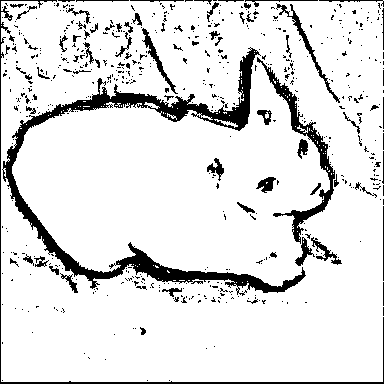

In [88]:
predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)
predictions = Image.fromarray(np.uint8(predictions*255))
predictions = predictions.resize((img.width, img.height))

predictions.save('predicted_image.jpg')
predictions